<a href="https://colab.research.google.com/github/jav0927/course-v3/blob/master/SSD_Object_Detection_RS50_V2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## SSD Single Shot  Multibox Object Detection (Version 2.0)
This model is a Fastai V1 iplementation of professor Jeremy Howard's work introduced in lesson 1 of 2018 Cutting  Edge Deep Learning for Coders, Part 2,  originally written in Fastai V0.7. This is the most challenging model in the course, but also a great instructional tool. In developing this model, i was inspired by previous work by Heye.

J. A. Villalobos @ 2019. wolves.lair@icloud.com

### Version Date: 10/18/2019

### V2.0 Enhancements
1. Changed the architecture to RESNET50
2. Enhanced the model with a couple of booster conv2 layers to increase the 
power of the model to recognize small objects
3. Added prediction code at the end of the notebook to test external images  with and without NMS
4. Added a model export section that creates a .pkl file. This file is read by the external image prediction section, which can be in a separate computer

### V3.0 Work in Progress
   1. Enhanced data augmentation. Implementation of the paper "Learning Data Augmentation Strategies for Object Detection" by Barret Zoph, Elkin Cubuk, et. al.
   2. Mechanism to calculate Mean Average Precision mPA

### Initialization

In [0]:
# Hardware performance enhancements
import os
NUM_PARALLEL_UNITS = 4
os.environ["OMP_NUM_THREADS"] = "8"
os.environ["KMP_BLOCKTIME"] = "0"
os.environ["KMP_SETTINGS"] = "1"
os.environ["KMP_AFFINITY"] = "granularity=fine, verbose, compact, 1, 0"

In [0]:
# Connect Google drive to Colab for file saving and loading.
from google.colab import drive
drive.mount('/content/gdrive')
from google.colab import files

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# Set up nline plotting
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [0]:
# Load Fastai libraries
from fastai.vision import *
from fastai import *
from fastai.callbacks import *
__version__

'1.0.58'

In [0]:
# Automatically sets for GPU or CPU environments
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  

###Download Pascal 20007 database

In [0]:
# Download {Pascal 20007 database}
path = untar_data(URLs.PASCAL_2007); path.ls()

[PosixPath('/root/.fastai/data/pascal_2007/train'),
 PosixPath('/root/.fastai/data/pascal_2007/valid.json'),
 PosixPath('/root/.fastai/data/pascal_2007/test'),
 PosixPath('/root/.fastai/data/pascal_2007/test.json'),
 PosixPath('/root/.fastai/data/pascal_2007/train.json')]

### Data Preparation

In [0]:
# Collect image names, bound box coordinates, and categories into lists
# for train and test data sets
trn_im_names, trn_truths = get_annotations(path/'train.json')
val_im_names, val_truths = get_annotations(path/'valid.json')
tst_im_names, tst_truths = get_annotations(path/'test.json') 

# Combine Train and Validation set into a sigle dataset
# (which will be split later by the data block)
tot_im_names, tot_truths = [trn_im_names + val_im_names, trn_truths + val_truths]

# Create a dictionary containing the composite of the above
img_y_dict = dict(zip(tot_im_names, tot_truths))

# Define a function, based on the dictionary created above, to use in a Fastai Data Block to structure the input data
truth_data_func = lambda o: img_y_dict[o.name]

### Create Fastai DataBunch

In [0]:
sz=224       # Image size
bs=64        # Batch size

In [0]:
tfms = get_transforms(xtra_tfms=cutout(n_holes=(1,4), length=(2, 70), p=.5, use_on_y=False), max_rotate=4., 
                      max_zoom=1.1, p_affine=0.5, p_lighting=0.5 )

In [0]:
# This code was necessary because Fastai has not been updated to handle a change in Python 1.3.0. It suppresses a warning message that is repeated endlessly. 
#import warnings
#warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.functional")

In [0]:
np.random.seed(35)

data = (ObjectItemList
        .from_folder(path/'train')
        .split_by_rand_pct(0.2)
        .label_from_func(truth_data_func) 
        .transform(tfms=tfms,size=sz,tfm_y=True,resize_method=ResizeMethod.SQUISH)
        .databunch(bs=bs,collate_fn=bb_pad_collate,num_workers=8)
        .normalize(imagenet_stats)
       )

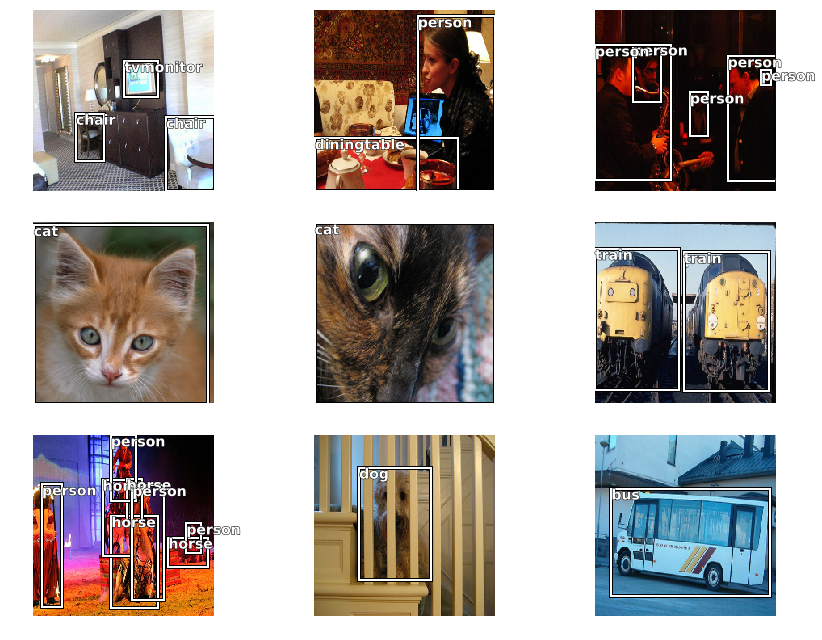

In [0]:
data.show_batch(rows=3, figsize=(12,9))

### Show single image

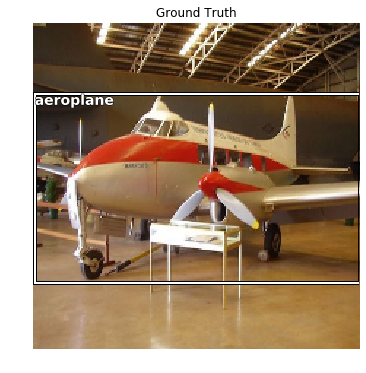

In [0]:
# Show test image
idx = 48

xb, yb= next(iter(data.valid_dl))

img = vision.Image(denormalize(xb[idx], *tensor(imagenet_stats)))
img_box = ImageBBox.create(sz, sz, yb[0][idx].cpu(), labels=yb[1][idx], classes=data.classes, scale=False)

fig, axes = plt.subplots(1, 1, figsize=(10,6))
img.show(ax=axes, y=img_box, title="Ground Truth")

### Helper Functions 

In [0]:
# Filter out all zero-valued bounding boxes
def un_pad(boxes,labels):
    bb_keep = ((boxes[:,2] - boxes[:,0])>0).nonzero()[:,0]
    return boxes[bb_keep],labels[bb_keep]

# Calculate the area of a bounding box
def box_area(boxes):
    return (boxes[:,2] - boxes[:,0]) * (boxes[:,3] - boxes[:,1])

# Calculate the intersection of two given bounding boxes
def intersect(box_a,box_b):
    #make sure box_a and box_b exists, otherwise undefine behavior if you call the func
    top_left = torch.max(box_a[:,None,:2],box_b[None,:,:2])
    bot_right = torch.min(box_a[:,None,2:],box_b[None,:,2:])
    inter = torch.clamp((bot_right - top_left),min=0)
    return inter[:,:,0] * inter[:,:,1]

# Calculate Jaccard (IOU)
def iou(bbox,anchor):
    #bbox is gt_bb, anchor is anchor box, all in fastai style
    if len(bbox.shape) == 1: bbox = bbox[None,...]
    inter = intersect(bbox,anchor)
    union = box_area(bbox).unsqueeze(dim=1) + box_area(anchor).unsqueeze(dim=0) - inter #to broadcast shape to (N,16),where N is number of gt_bb for single image
    return inter / union

# Display generated anchor grid
def show_anchors(ancs, size):
    _,ax = plt.subplots(1,1, figsize=(5,5))
    ax.set_xticks(np.linspace(-1,1, size[1]+1))
    ax.set_yticks(np.linspace(-1,1, size[0]+1))
    ax.grid(True, which='both')
    ax.scatter(ancs[:,1], ancs[:,0]) #y is first
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_xlim(-1,1)
    ax.set_ylim(1,-1) #-1 is top, 1 is bottom
    for i, (x, y) in enumerate(zip(ancs[:, 1], ancs[:, 0])): ax.annotate(i, xy = (x,y))

#convert center/height/width to fastai top left and bottom right coordinates
def cthw2corners(boxes):
    top = (boxes[:,0] - boxes[:,2]/2).view(-1,1)
    left = (boxes[:,1] - boxes[:,3]/2).view(-1,1)
    bot = (boxes[:,0] + boxes[:,2]/2).view(-1,1)
    right = (boxes[:,1] + boxes[:,3]/2).view(-1,1)
    return torch.cat([top,left,bot,right],dim=1)

# Transform activations to bounding box format
def act_to_bbox(activation,anchor):
    activation = torch.tanh(activation) #force scale to be -1,1
    act_center = anchor[:,:2] + (activation[:,:2]/2 * grid_sizes.float().to(activation.device))
    act_hw = anchor[:,2:] * (activation[:,2:]/2 + 1)
    return cthw2corners(torch.cat([act_center,act_hw],dim=1))

  # Map to Ground Truth
def map_to_gt(overlaps):
    prior_overlap,prior_idx = overlaps.max(dim=1)
    sec_overlap,sec_idx = overlaps.max(dim=0)
    sec_overlap[prior_idx] = 4.99
    for i,o in enumerate(prior_idx): 
        sec_idx[o] = i
    return sec_overlap,sec_idx

### Helper Functions - Anchor Boxes

In [0]:
# Anchor Boxes
anc_grids = [4, 2, 1]
anc_zooms = [0.75, 1., 1.3]
anc_ratios = [(1., 1.), (1., 0.5), (0.5, 1.)]

anchor_scales = [(anz*i,anz*j) for anz in anc_zooms 
                                    for (i,j) in anc_ratios]
# *** Number of Anchor Scales
k = len(anchor_scales)
# ***************************

anc_offsets = [2/(o*2) for o in anc_grids] #2 is the h,w in fastai 1.0 (-1,1)
anc_x = np.concatenate([np.repeat(np.linspace(ao-1, 1-ao, ag), ag)
                        for ao,ag in zip(anc_offsets,anc_grids)])
anc_y = np.concatenate([np.tile(np.linspace(ao-1, 1-ao, ag), ag)
                        for ao,ag in zip(anc_offsets,anc_grids)])
anc_ctrs = np.repeat(np.stack([anc_x,anc_y], axis=1), k, axis=0)
anc_sizes = np.concatenate([np.array([[2*o/ag,2*p/ag] 
              for i in range(ag*ag) for o,p in anchor_scales])
                 for ag in anc_grids]) #2/grid * scale,2 is the h,w in fastai 1.0
grid_sizes = tensor(np.concatenate([np.array([ 1/ag 
              for i in range(ag*ag) for o,p in anchor_scales])
                  for ag in anc_grids])).unsqueeze(1) *2 #again fastai 1.0 h,w is 2
anchors = tensor(np.concatenate([anc_ctrs, anc_sizes], axis=1)).float()
anchor_cnr = cthw2corners(anchors)


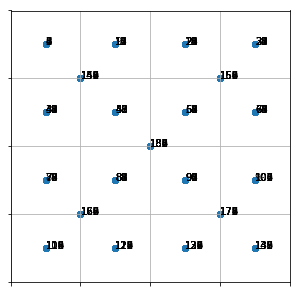

In [0]:
show_anchors(anchors,(4,4))

### Optimal Learning Rate Search
This is my own version of Fastai's learn.recorder.plot(). For an explanation of how it works and how to use it, go to my post Selecting Learn Rates in Fastai, https://forums.fast.ai/t/selecting-learn-rates-in-fastai/51929

In [0]:
def is_unfreeze(learner):
    '''
    Determines whether the next-to-last layer in the model is set to unfreeze or freeze
    '''
    c = 0
    for each in list(learner.model.body[-1][0].parameters()):
      if each.requires_grad: c += 1   
    if c == len(list(learner.model.body[-1][0].parameters())):
      return True 
    else:
      return False
    
  
  
def find_optimal_lr(learner, noise=1, show_df=None, show_min_values=False):
    '''
    Parameters
    
      learner:  The learner (mandatory)
      
      (Optional)
      noise:   Filtering parameter, set to 3. Suggest no to modify this value
      
      show_df: 'head' - Show the top 50 rows, 
               'tail' - Show the tail 50 rows
    
      show_min_values: True  - Display all values, min, and max 
                       False - Display min_loss and max_grad values
    
    Returns:
      optimun_lr - if freeze = True
      Suggested Best Slice - if freeze = False
      
    Author:  J. Adolfo Villalobos @ 2019  
    '''
    
    # Get loss values, corresponding gradients, and lr values from model.recorder
    loss = np.array(learner.recorder.losses)
    loss_grad = np.gradient(loss)   
    # Transform lrs list to np array
    lrs = np.array(learner.recorder.lrs, dtype='float32')
    
    # Create a DataFrame with the data
    data = {'loss': loss.T, 'loss_grad': loss_grad.T, 'lrs': lrs.T}
    df = pd.DataFrame(data, columns=['loss', 'loss_grad', 'lrs', 'min_loss', 'max_loss', 'min_grad', 'max_grad'])
      
    # Populate "min" and "max" columns for loss and gradient values filtering the noise with argrelextrema.     
    from scipy.signal import argrelextrema
    
    #********
    # IMPORTANT: n filters noise (sharp spikes in the data). Higher n value filters noise more aggressively. 
    # n = 3 seems to work best
    n=noise    
    #********
    
    df.min_loss = df.iloc[argrelextrema(df.loss.values, np.less_equal, order=n)[0]]['loss']
    df.max_loss = df.iloc[argrelextrema(df.loss.values, np.greater_equal, order=n)[0]]['loss']
    df.min_grad = df.iloc[argrelextrema(df.loss_grad.values, np.less_equal, order=n)[0]]['loss_grad']
    df.max_grad = df.iloc[argrelextrema(df.loss_grad.values, np.greater_equal, order=n)[0]]['loss_grad']

    # Optional: Display dataframe if show_df=True
    if show_df == 'head': print(df.head(50)) 
    elif show_df == 'tail': print(df.tail(50))     
        
    # Plot losses and loss gradients against lr values
    plt.figure(figsize=[8, 5])
    #figs, ax = plt.subplots(1,1)
    ax = plt.gca()
    color_loss = 'blue'
    color_grad = 'orange'
    color_green = 'green'
    color_red = 'red'

    ax.xaxis.grid(True)
    ax.set_ylabel('Loss')
    ax.set_title('Learn Rate Finder')
    ax.tick_params(axis='y', labelcolor=color_loss)
    ax.semilogx(df.lrs, df.loss, c=color_loss, label='loss' )
    
    # Define variable vertical size of the plot window, depending on the graph shape
    u_limit = max(df.loss.loc[(df.lrs < 0.1)].max(), 250)*2    
    ax.set_ylim([-200, u_limit])
   
    # Plot resulting line graphs
    ax2 = ax.twinx()
    ax2.set_ylabel('loss', color= color_grad)
    ax2.semilogx(df.lrs, df.loss_grad, c = color_grad, label='loss_grad' )
    ax2.tick_params(axis='y', labelcolor = color_grad)
    
    # plot inflection points
    ax.scatter(df.lrs, df.min_loss, c = color_red, label='min_loss' )    
    ax2.scatter(df.lrs, df.min_grad, c = color_red, label='min_grad' )    
    if show_min_values:
      ax.scatter(df.lrs, df.max_loss, c = color_green, label='max_loss' )
      ax2.scatter(df.lrs, df.max_grad, c = color_green, label='max_grad' ) 
    
    # Legends
    plt.LogFormatter(labelOnlyBase=False)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.0), ncol=3, fancybox=True, shadow=True)
    ax2.legend(loc='upper center', bbox_to_anchor=(0.5, 0.9), ncol=3, fancybox=True, shadow=True)
    plt.show()
    
    # Display resulting lr values, format varies depending of the state of the model's 
    # next-to-last layer ggroup: set to freeze or unfreeze    
    if is_unfreeze(learner):
      # Yellow min_grad graph
      rev_tru_idx = df.min_grad.notna()[::-1]   
      optimun_lr_upper_bound_g = df.lrs.iloc[rev_tru_idx.idxmax()] 
      rev_tru_idx[rev_tru_idx.idxmax()] = np.NaN      
      optimun_lr_lower_bound_1_g = df.lrs.iloc[rev_tru_idx.idxmax()]
      rev_tru_idx[rev_tru_idx.idxmax()] = np.NaN      
      optimun_lr_lower_bound_2_g = df.lrs.iloc[rev_tru_idx.idxmax()] 
      
      # Blue loss graph
      rev_tru_idx_loss = df.min_loss.notna()[::-1]   
      optimun_lr_upper_bound_l = df.lrs.iloc[rev_tru_idx_loss.idxmax()] 
      rev_tru_idx_loss[rev_tru_idx_loss.idxmax()] = np.NaN      
      optimun_lr_lower_bound_1_l = df.lrs.iloc[rev_tru_idx_loss.idxmax()]
      rev_tru_idx_loss[rev_tru_idx_loss.idxmax()] = np.NaN      
      optimun_lr_lower_bound_2_l = df.lrs.iloc[rev_tru_idx_loss.idxmax()] 
      
      # Print results and return choices of lr slice
      print('Model set to: "unfreeze" or "freeze_to:"')      
      data = {'*Gradient - Orange Graph*' : [optimun_lr_upper_bound_g, optimun_lr_lower_bound_1_g, optimun_lr_lower_bound_2_g], 
              '*Loss - Blue Graph*' : [optimun_lr_upper_bound_l, optimun_lr_lower_bound_1_l, optimun_lr_lower_bound_2_l]}
      prdf = pd.DataFrame(data, index = ['First choice lr:', 'Second choice lr:', 'Third choice lr:' ])
      pd.options.display.float_format = '{:.10E}'.format
      #prdf.style.applymap('color: %s' % color_grad, subset=['*Gradient - Orange Graph*'])
      print(prdf)
       
      return optimun_lr_lower_bound_1_g, optimun_lr_upper_bound_g
      
    else:
        
      optimun_lr_upper_bound = df.lrs.iloc[df.min_grad.notna()[::-1].idxmax()]
      optimun_lr_lower_bound = df.lrs.iloc[df.min_loss.notna()[::-1].idxmax()]/10
      # Print results and return optimal lr
      print('Model set to "freeze":')
      print('  Optimun lr: {:.10E} '.format(optimun_lr_upper_bound))
      print('  Min loss divided by 10: {:.10E}'.format(optimun_lr_lower_bound))
      return optimun_lr_upper_bound 
     

### Preserve data classes for use in Validation and Testing

In [0]:
# Number of classes in the data set
no_cls = len(data.classes); no_cls

21

In [0]:
# Copy Data Classes for Future Use in Testing External Images
data_classes = data.classes.copy()
#data_classes

In [0]:
# Save the Classes in a file for use later in the section that predicts external images (which can be run on a separate computer)
with open(F'/content/gdrive/My Drive/ssd_classes', 'wb') as fp:
    pickle.dump(data_classes, fp)

### Model

To solve this object detection problem, we are going to create a custom model using Torch.
The architecture chosen is Single Shot Detection, described in the paper SSD: Single Shot Multibox Detector by Wei Liu, et. al.
The model uses a pretrained ResNet, to which we add the components required for object detetion. The chosen backbone architecture is ResNet50.

In [0]:
# model 
f_model = models.resnet50

In [0]:
# Method used to match the shape of the conv_ssd_layer to the ground truth's shape
def y_handoff (x,k):
    # Reshape ssd output to match truth's shape 
    # Must return size of bs,r*c,nf
    # y structure is (16,4),(16,21) single item style
    bs,nf,row,col = x.shape
    x = x.view(bs,nf//k,-1)
    return x.permute(0,2,1)
    

# Standard convolution with stride=2 to halve the size of the image
class conv2_std_layer(nn.Module):
    def __init__(self, ni, nf, stride=2, drop=0.1):
        super().__init__()
        self.cnv = conv_layer(ni, nf, stride=stride)
        self.drp = nn.Dropout(drop)
        
    def forward(self, x):
        return self.drp(self.cnv(x))

# SSD convolution that camptures bounding box and class
class conv2_ssd_layer(nn.Module):
    def __init__(self, ni, k, no_cls):
        super().__init__()
        self.k = k 
        self.conv_class = conv2d(ni, no_cls*self.k, bias=True)
        self.conv_bbox = conv2d(ni, 4*self.k, bias=True)
        
    
    def forward(self, x):
        label = self.conv_class(x)
        box = self.conv_bbox(x)
        return [y_handoff(box, self.k), y_handoff(label, self.k)]

In [0]:
class ssd_model(nn.Module):
    def __init__(self, arch=models.resnet34, k=9 , drop=0.4, no_cls=21):
        super().__init__()
        self.k = k
        self.body = create_body(arch)
        self.drop = nn.Dropout(0.4)   # it was 0.25

        self.std_conv_0 = conv2_std_layer(num_features_model(self.body), 256, drop=drop,stride=1)
        # Dimension-reducing  layers
        self.std_conv_1 = conv2_std_layer(256, 256, drop=drop, stride=2) # 4 by 4 layer
        self.std_conv_1_1 = conv_layer(256, 256, stride=1)  # Booster layer
        self.std_conv_2 = conv2_std_layer(256, 256, drop=drop, stride=2) # 2 by 2 layer
        self.std_conv_1_2 = conv_layer(256, 256, stride=1)  # Booster layer
        self.std_conv_3 = conv2_std_layer(256, 256, drop=drop, stride=2) # 1 by 1 layer
        # SSD layers
        self.ssd_conv_1 = conv2_ssd_layer(256, k=self.k, no_cls=no_cls)
        self.ssd_conv_2 = conv2_ssd_layer(256, k=self.k, no_cls=no_cls)
        self.ssd_conv_3 = conv2_ssd_layer(256, k=self.k, no_cls=no_cls)
        
    def forward(self, xb):
        xb = self.drop(F.relu(self.body(xb)))
        xb = self.std_conv_0(xb)
        xb = self.std_conv_1(xb)
        xb = self.std_conv_1_1(xb)
        bb1, cls1 = self.ssd_conv_1(xb) # 4 x 4
        xb = self.std_conv_2(xb)
        xb = self.std_conv_1_2(xb)
        bb2, cls2 = self.ssd_conv_2(xb) # 2 x 2
        xb = self.std_conv_3(xb)     
        bb3, cls3  = self.ssd_conv_3(xb) # 1 x 1
        
        return [torch.cat([bb1, bb2, bb3], dim=1), 
                torch.cat([cls1, cls2, cls3], dim=1)]

### SSD Loss

---


In [0]:
# Focal loss implementation
def get_weight(x,t):
    x,t = x.cpu(),t.cpu()
    alpha,gamma = 0.25,1
    p = x.sigmoid()
    pt = p*t + (1-p)*(1-t)
    w = alpha*t + (1-alpha)*(1-t)
    return w * (1-pt).pow(gamma)
    
# Class loss computation, based on Binary Cross Entrophy with Logits
def bceloss(pred,target,num_classes,focal_loss=False):
    
    t = torch.eye(num_classes)[target.detach().cpu()][:,1:]
    p = pred[:,1:]
    
    w = get_weight(p,t) if focal_loss else None
    return F.binary_cross_entropy_with_logits(p.cpu(),t,weight=w.detach(),reduction='sum') / (num_classes-1)

# Bounding-box loss computation, based on fixed Anchor Boxes and L! Loss
def single_ssd_loss(pbox,plabel,box,label):
    # IOU Threshold. Keep overlaps with iou above this level
    threshold = 0.4
    
    # Compute the jaccard (overlap) between ground truth and anchor boxes
    anchor_box = anchors
    base_box = cthw2corners(anchor_box) # Map anchors into Fastai format: top-left and bottom-right coordinates
    bbox,clas = un_pad(box,label) # Filter all non-zero boxes
    overlaps = iou(bbox,base_box.to(device))  # Calculate iou for anchor and target box
    try:
        gt_overlaps,gt_idx = map_to_gt(overlaps)
    except:
        return 0,0
    # Map gt_idx back to classes for multi label classfication
    gt_clas = clas[gt_idx]
    
    # Positive predictions have overlaps greater than 0.4
    pos = gt_overlaps > threshold

    #************************************************
    # Fix for "mask inversion problem" in PyTorch 1.2 (10/22/19)
    #gt_clas[1-pos] = len(data.classes) Used to be ... 
    gt_clas[~pos] = len(data.classes)
    # ***********************************************

    gt_label = [o.item() if o < len(data.classes) else 0 for o in gt_clas.detach()] #Ground truth labels
    pos_idx = torch.nonzero(pos)[:,0] 
    gt_bbox = bbox[gt_idx]  # Selected ground truth box
    
    # Map predicted bounding box to anchor and convert it to Fastai format: top-left and bottom-right coordinates
    p_final_box = act_to_bbox(pbox,anchor_box.to(device)) 
    
    #L1 loss calculation
    loc_loss = ((p_final_box[pos_idx] - gt_bbox[pos_idx]).abs()).mean()
    
    #Multi classification
    label_loss = bceloss(plabel,tensor(gt_label),data.c,focal_loss=True)
    return loc_loss,label_loss

# Loop through each of the y_hat and y pairs 
def ssd_loss(preds,*targets,print_it=False):
    batch_loc_loss,batch_label_loss = 0., 0.
    for p_box,p_label,box,label in zip(*preds,*targets):
        loc_loss,label_loss = single_ssd_loss(p_box,p_label,box,label)
        batch_loc_loss = batch_loc_loss + loc_loss
        batch_label_loss = batch_label_loss + label_loss
    total_loss = batch_loc_loss + batch_label_loss.to(device)
    if print_it: print(batch_loc_loss,batch_label_loss)
    return total_loss
  
# loss function
loss_f = ssd_loss

### Learner

In [0]:
md = ssd_model(f_model, k=k, no_cls=no_cls, drop=0.4)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:05<00:00, 19.0MB/s]


In [0]:
learn = Learner(data, md, loss_func=loss_f)

### Split Model

In [0]:
learn.split(lambda m: (m.body[6], m.drop))
learn.layer_groups

### Fit

#### initial Training Run (on freeze)

In [0]:
# Find Finder
learn.freeze()
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


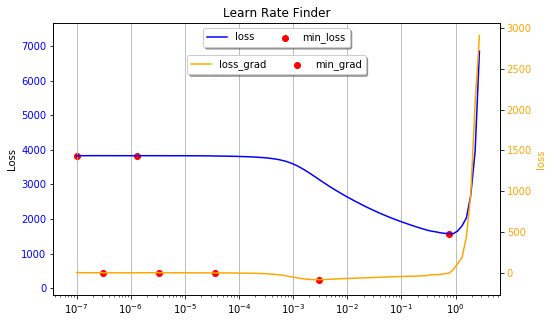

Model set to "freeze":
  Optimun lr: 3.0199517496E-03 
  Min loss divided by 10: 7.5857758522E-02


In [0]:
# Find Optimal Learning Rates
lr =  find_optimal_lr(learn);

In [0]:
learn.fit_one_cycle(10, slice(3.0199517496E-03, 3.0e-02) )

In [0]:
#learn.fit_fc(), needs RADAM

In [0]:
learn.save(F'/content/gdrive/My Drive/ssd_basic')

In [0]:
learn.load(F'/content/gdrive/My Drive/ssd_basic', strict=True)

#### Train Last Two Layers

In [0]:
learn.split(lambda m: (m.body[6],m.drop))
learn.freeze_to(-2)

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


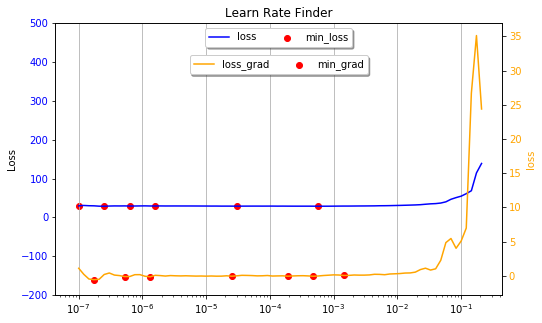

Model set to: "unfreeze" or "freeze_to:"
                   *Gradient - Orange Graph*  *Loss - Blue Graph*
First choice lr:            1.4454397606E-03     5.7543994626E-04
Second choice lr:           4.7863009968E-04     3.0199516914E-05
Third choice lr:            1.9054606673E-04     1.5848931980E-06


In [0]:
# Find Optimal Learning Rates
lr =  find_optimal_lr(learn)

In [0]:
learn.fit_one_cycle(10, slice(2.5e-05 , 4.7863009968E-04))

In [0]:
learn.save(F'/content/gdrive/My Drive/ssd_freeze_2_1_rs50')

In [0]:
learn.load(F'/content/gdrive/My Drive/ssd_freeze_2_1_rs50', strict=True)

In [0]:
learn.split(lambda m: (m.body[6],m.drop))
learn.freeze_to(-2)

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


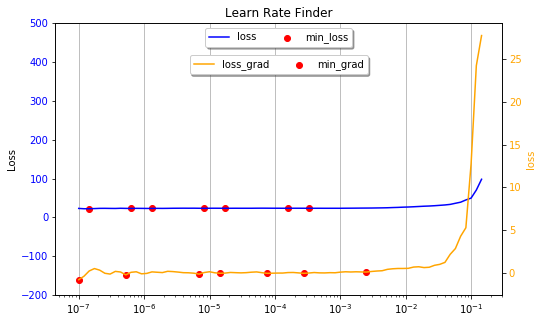

Model set to: "unfreeze" or "freeze_to:"
                   *Gradient - Orange Graph*  *Loss - Blue Graph*
First choice lr:            2.5118864141E-03     3.3113113022E-04
Second choice lr:           2.7542287717E-04     1.5848931798E-04
Third choice lr:            7.5857758929E-05     1.7378008124E-05


In [0]:
# Find Optimal Learning Rates
lr =  find_optimal_lr(learn)

In [0]:
learn.fit_one_cycle(10, slice(2.5118864141E-03))

In [0]:
learn.save(F'/content/gdrive/My Drive/ssd_unfreeze_2_2')

In [0]:
learn.load(F'/content/gdrive/My Drive/ssd_unfreeze_2_2', strict=True)

In [0]:
learn.split(lambda m: (m.body[6], m.drop))
learn.freeze_to(-2)

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


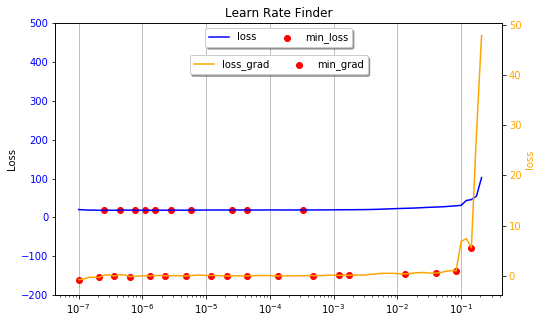

Model set to: "unfreeze" or "freeze_to:"
                   *Gradient - Orange Graph*  *Loss - Blue Graph*
First choice lr:            1.4454397559E-01     3.3113113022E-04
Second choice lr:           8.3176374435E-02     4.3651583837E-05
Third choice lr:            3.9810717106E-02     2.5118864869E-05


In [0]:
lr = find_optimal_lr(learn, noise=1)

In [0]:
learn.fit_one_cycle(13, slice(3.5e-05, 3.3113113022E-04))

In [0]:
learn.save(F'/content/gdrive/My Drive/ssd_unfreeze_2_3_rs50')

In [0]:
learn.load(F'/content/gdrive/My Drive/ssd_unfreeze_2_3_rs50', strict=True)

#### Unfreeze and Train

In [0]:
learn.split(lambda m: (m.body[6], m.drop))
learn.unfreeze()

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


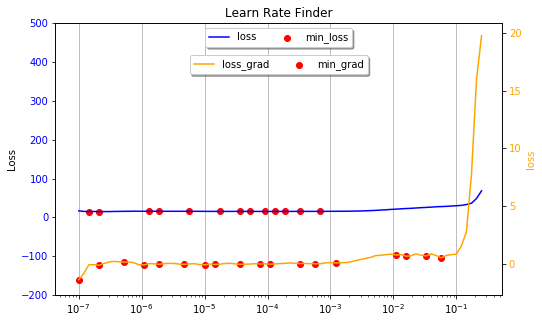

Model set to: "unfreeze" or "freeze_to:"
                   *Gradient - Orange Graph*  *Loss - Blue Graph*
First choice lr:            5.7543992996E-02     6.9183099549E-04
Second choice lr:           3.3113110811E-02     3.3113113022E-04
Third choice lr:            1.5848932788E-02     1.9054606673E-04


In [0]:
lr = find_optimal_lr(learn, noise=1)

In [0]:
learn.fit_one_cycle(20, slice(6.9183099549E-04))

In [0]:
learn.save(F'/content/gdrive/My Drive/ssd_unfreeze_4_rs50')

In [0]:
learn.load(F'/content/gdrive/My Drive/ssd_unfreeze_4_rs50', strict=True)

In [0]:
learn.split(lambda m: (m.body[6], m.drop))
learn.unfreeze()

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


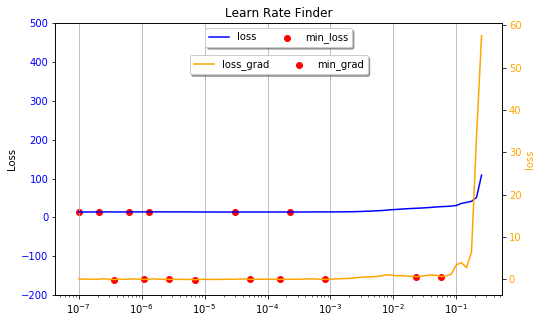

Model set to: "unfreeze" or "freeze_to:"
                   *Gradient - Orange Graph*  *Loss - Blue Graph*
First choice lr:            5.7543992996E-02     2.2908677056E-04
Second choice lr:           2.2908676416E-02     3.0199516914E-05
Third choice lr:            8.3176378394E-04     1.3182567500E-06


In [0]:
lr = find_optimal_lr(learn)

In [0]:
learn.fit_one_cycle(20, slice( 2.2908677056E-04))

In [0]:
learn.save(F'/content/gdrive/My Drive/ssd_unfreeze_5_rs50')

In [0]:
learn.load(F'/content/gdrive/My Drive/ssd_unfreeze_5_rs50', strict=True)

In [0]:
learn.split(lambda m: (m.body[6], m.drop))
learn.unfreeze()

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


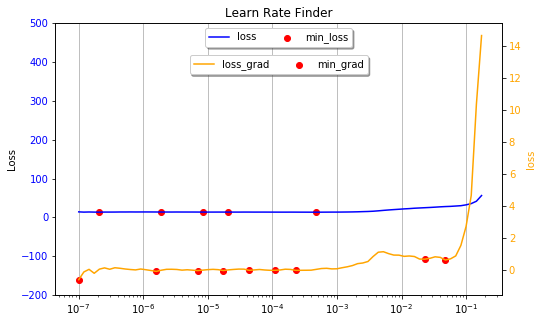

Model set to: "unfreeze" or "freeze_to:"
                   *Gradient - Orange Graph*  *Loss - Blue Graph*
First choice lr:            4.7863010317E-02     4.7863009968E-04
Second choice lr:           2.2908676416E-02     2.0892961402E-05
Third choice lr:            2.2908677056E-04     8.3176373664E-06


In [0]:
lr = find_optimal_lr(learn, noise=3)

In [0]:
learn.fit_one_cycle(20, slice(5.75E-04))

In [0]:
learn.save(F'/content/gdrive/My Drive/ssd_unfreeze_6')

In [0]:
learn.fit_one_cycle(20, slice(2.0E-5))

In [0]:
learn.save(F'/content/gdrive/My Drive/ssd_unfreeze_7')

In [0]:
learn.load(F'/content/gdrive/My Drive/ssd_unfreeze_7', strict=True)

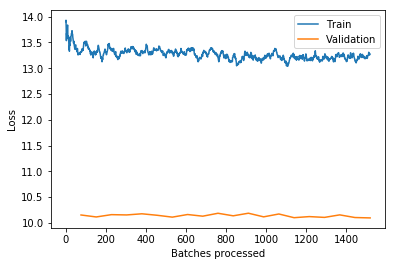

In [0]:
learn.recorder.plot_losses()

### Export Model
Export model into a .pkl file for use in testing of external images (perhaps in a different computer)

In [0]:
learn.export(F'/content/gdrive/My Drive/model_export.pkl')

In [0]:
process_mpa(learn.data.valid_dl, bs)

### Predict validation images ( No NMS)

In [0]:
# Get batch from valid dataset
xb,yb = next(iter(learn.data.valid_dl))
xb.shape

torch.Size([64, 3, 224, 224])

In [0]:
# Predict results based on the input image batch
learn.model.eval()
preds = learn.model(xb)

In [0]:
# Select sample image and unpad it
idx = 0
t_bbox,t_clas = un_pad(yb[0][idx],yb[1][idx])
#t_bbox,t_clas

# Predicted class
p_cls_test = preds[1][idx][:,1:].max(dim=1)
#p_cls_test

# Threshold
idx_clas = p_cls_test[0].sigmoid() > 0.1
#idx_clas


p_f_clas = (p_cls_test[1] + 1) * (idx_clas).long()
#p_f_clas

In [0]:
def show_img_by_ndx(idx):
    t_bbox,t_clas = un_pad(yb[0][idx],yb[1][idx])
    p_cls_test = preds[1][idx][:,1:].max(dim=1)
    idx_clas = p_cls_test[0].sigmoid() > 0.1
    p_f_clas = (p_cls_test[1] + 1) * (idx_clas).long()
    img = vision.Image(denormalize(xb[idx],*tensor(imagenet_stats)))
    img_box = ImageBBox.create(224,224,yb[0][idx].cpu(),labels=yb[1][idx],classes=data.classes,scale=False)


    p_final_bbox = act_to_bbox(preds[0][idx].cpu(),anchors)
    t_bbox = p_final_bbox.to(device).index_select(dim=0,index=idx_clas.nonzero().squeeze())
    test_clas = p_f_clas.index_select(dim=0,index=idx_clas.nonzero().squeeze())
    p_img_box = ImageBBox.create(224,224,t_bbox.cpu(),test_clas,classes=data.classes,scale=False)

    fig,axes = plt.subplots(1,2,figsize=(10,6))
    img.show(ax=axes[0],y=img_box,title='Ground Truth')
    img.show(ax=axes[1],y=p_img_box,title='Prediction')

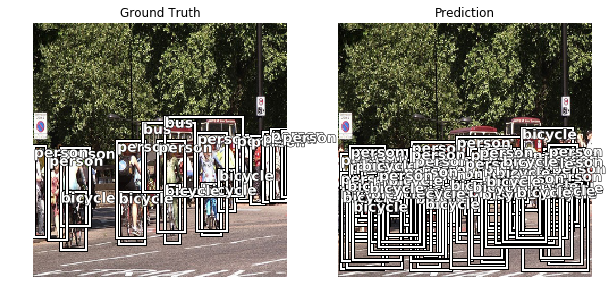

In [0]:
show_img_by_ndx(2)

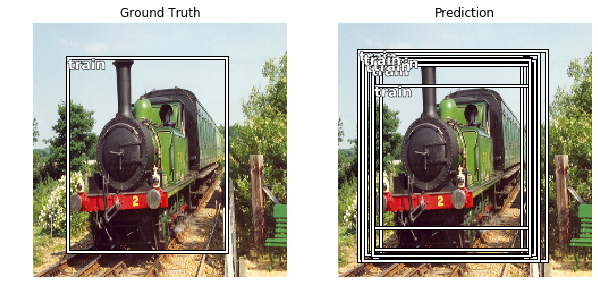

In [0]:
show_img_by_ndx(2)

### Color Coding Setup

In [0]:
import matplotlib.cm as cmx
import matplotlib.colors as mcolors
from cycler import cycler

def get_cmap(N):
    color_norm  = mcolors.Normalize(vmin=0, vmax=N-1)
    return cmx.ScalarMappable(norm=color_norm, cmap='Set3').to_rgba

num_colr = 12
cmap = get_cmap(num_colr)
colr_list = [cmap(float(x)) for x in range(num_colr)]

### NMS  Algorithm

In [0]:
def nms(boxes, scores, overlap=0.5, top_k=100):
    keep = scores.new(scores.size(0)).zero_().long()
    if boxes.numel() == 0: return keep
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]
    area = torch.mul(x2 - x1, y2 - y1)
    v, idx = scores.sort(0)  # sort in ascending order
    idx = idx[-top_k:]  # indices of the top-k largest vals
    xx1 = boxes.new()
    yy1 = boxes.new()
    xx2 = boxes.new()
    yy2 = boxes.new()
    w = boxes.new()
    h = boxes.new()

    count = 0
    while idx.numel() > 0:
        i = idx[-1]  # index of current largest val
        keep[count] = i
        count += 1
        if idx.size(0) == 1: break
        idx = idx[:-1]  # remove kept element from view
        # load bboxes of next highest vals
        torch.index_select(x1, 0, idx, out=xx1)
        torch.index_select(y1, 0, idx, out=yy1)
        torch.index_select(x2, 0, idx, out=xx2)
        torch.index_select(y2, 0, idx, out=yy2)
        # store element-wise max with next highest score
        xx1 = torch.clamp(xx1, min=x1[i])
        yy1 = torch.clamp(yy1, min=y1[i])
        xx2 = torch.clamp(xx2, max=x2[i])
        yy2 = torch.clamp(yy2, max=y2[i])
        w.resize_as_(xx2)
        h.resize_as_(yy2)
        w = xx2 - xx1
        h = yy2 - yy1
        # check sizes of xx1 and xx2.. after each iteration
        w = torch.clamp(w, min=0.0)
        h = torch.clamp(h, min=0.0)
        inter = w*h
        # IoU = i / (area(a) + area(b) - i)
        rem_areas = torch.index_select(area, 0, idx)  # load remaining areas)
        union = (rem_areas - inter) + area[i]
        IoU = inter/union  # store result in iou
        # keep only elements with an IoU <= overlap
        idx = idx[IoU.le(overlap)]
    return keep, count

In [0]:
def process_nmf(idx, d_classes):
    '''
    Connects to the nmf algorith to filter out dupplicate bounding boxes
    ''' 
    # Minimun threshold for eliminating background noise
    min_thresh = 0.30     #0.25
    
    # Maximun threshold for eliminating duplicate boxes
    max_thresh = 0.1 
    
     # Extract predicted classes
    clas_pr, clas_ids = b_clas[idx].max(dim=1)
    
    # Mask Index of classes whose contents are over the noise level: 0 if the index contains no boxes, 1 if it does
    clas_pr = clas_pr.sigmoid()    
    
    # Calculate confidence score for Class Activations
    conf_scores = b_clas[idx].sigmoid().t().data  
    
    # Converts activation vectors to boxes. Shape: 189 x 4
    p_final_bbox = act_to_bbox(preds[0][idx].cpu(),anchors) 
    
    # lists for accumulating selected boxes and classes
    tot_bx, tot_cls = [], []
    
    scrd_cls_lst = d_classes.copy()
  
    # Loop across all classes
    for cl in range(0, len(conf_scores)):
        
        # Filter out Backgrounds and empty box arrays
        c_mask = conf_scores[cl] > min_thresh
        if c_mask.sum() == 0 or cl == 0: continue
        
        
        # scores for the selected class 
        scores = conf_scores[cl][c_mask] # Tensor 
            
        # These are active boxes. Ready to be processed by nmf
        boxes = p_final_bbox.to(device).index_select(dim=0,index=c_mask.nonzero().squeeze())
            
        # Run NMF
        ids, count = nms(boxes.data, scores, overlap=0.5, top_k=50)
        ids = ids[:count]
          
        # Filter all boxes & classes over the threshold and accumulate them in lists
        for i, (sc, bx) in enumerate(zip(scores, boxes.data[ids] )): 
                 
            tot_bx.append(bx)
            tot_cls.append(cl)
            # Create a scored label
            f = f'{i}: '           
            l = f'{d_classes[cl]} '
            s = '{0:.2f}'.format(sc) 
            sl = f+l+s
            # print('scored label: {} '.format(sl))
            scrd_cls_lst[cl] = sl

                
    if not tot_cls:
        print('Inferred Class is not recognized. It may be under the threshold.')
        return None, None, None  
    
    return torch.cat(tot_bx).view(-1, 4), torch.tensor((np.array(tot_cls))), scrd_cls_lst

### Predict validation images with NMS

In [0]:
tr = iter(learn.data.valid_dl)

In [0]:
# Get batch from valid dataset
xb,yb = next(tr)

In [0]:
# Predict results based on the input image batch
learn.model.eval()
preds = learn.model(xb)
b_bb, b_clas = preds

#### Filter Image for Display

In [0]:
def show_filtered_img_by_ndx(idx, d_classes):
        
    # Prepare ground-truth image for display
    img = vision.Image(denormalize(xb[idx],*tensor(imagenet_stats)))        
    img_box = ImageBBox.create(224,224,yb[0][idx].cpu(),labels=yb[1][idx],classes=d_classes,scale=False)
    
    # Unpad Y (ground-truth boxes and classes )
    t_bbox,t_clas = un_pad(yb[0][idx],yb[1][idx])
     
    # Process NMF 
    tot_bx, tot_cls, scrd_cls_lst = process_nmf(idx, d_classes)  # Filter dupplicate boxes
    if tot_bx is None: return 
    
    # Compose the image, bouding boxes, ans classes for display
    p_img_box = ImageBBox.create(224,224,tot_bx.cpu(),tot_cls.cpu(),classes=scrd_cls_lst,scale=False)
  
    # Display resulting image, selected bounding boxes, and class labels
    fig,axes = plt.subplots(1,2,figsize=(10,6))
    img.show(ax=axes[0],y=img_box,title='Ground Truth')
    img.show(ax=axes[1],y=p_img_box,title='Prediction', color=colr_list[11])

#### Display Image Sets

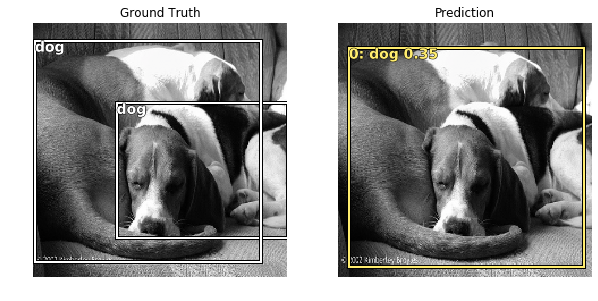

In [0]:
#Filter Image Sets
show_filtered_img_by_ndx(25, data_classes)

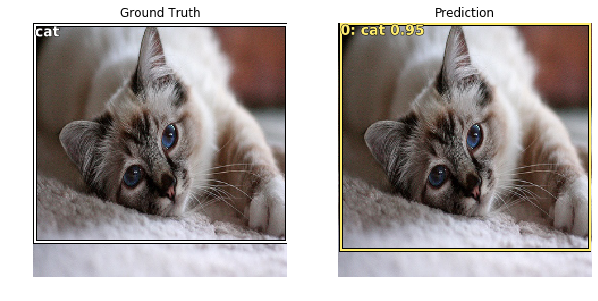

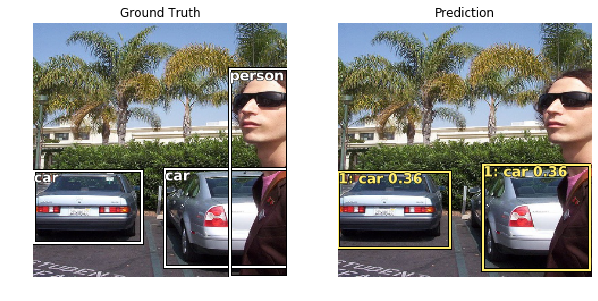

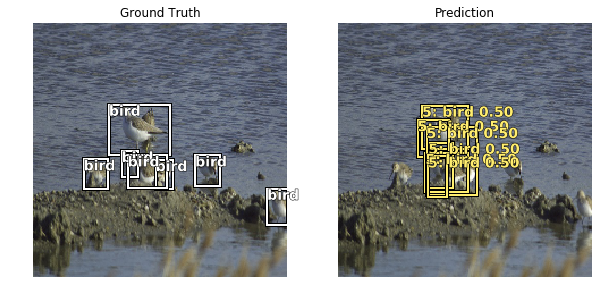

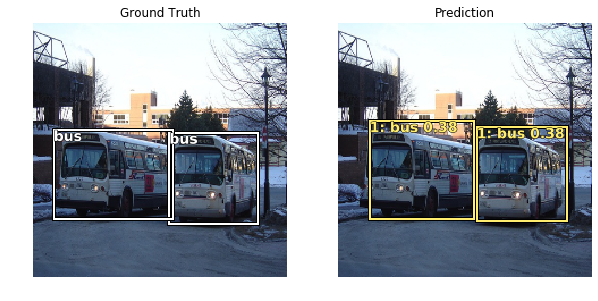

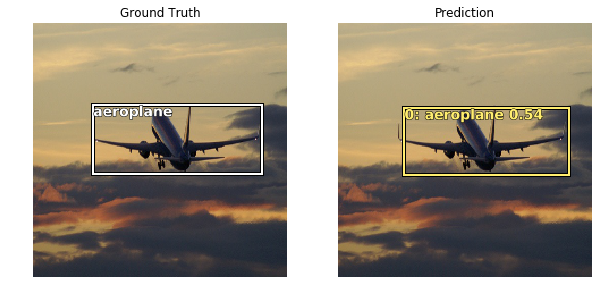

In [0]:
for i in range(5,10): show_filtered_img_by_ndx(i, data_classes)

## Model Tests with External Images
The section below tests the model with images that the model has never 'seen' before. The code below is kind of a hack. i have not been able to find an elegant method to infer external images using Fastai. If someone has a better way, I would love to learn from you. It is a pity that, given the advanced state of the Fastai library, it has yet to develop an adequate inference mechanism.
The code can be detached into a self-contained notebook that can be run in a separate computer. However, to run correctly, you must include a number of code cells from the main notebook. These are given by the cell heading name:

  ssd_loss

  ssd_model

  Helper Functions

  Helper Functions - Anchor Boxes

  Color Coding setup
  
  NMS Algorithm  (NMS, and process_nmf)

If you want to run the inference in a separate computer, I suggest you convert all the code listed above into .py files that you can refer to by means of import statements.

### Initialization

In [0]:
# ********************************************************************
# Do not run these cells unless you are running on a separate computer
#*********************************************************************
from google.colab import drive
drive.mount('/content/gdrive')
from google.colab import files

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
from fastai.vision import *
from fastai import *
from fastai.callbacks import *
import fastai
__version__

'1.0.58'

### Force the inference code to run under cpu only
Otherwise, you are likely to run out of GPU memory

In [0]:
# Force Fastai to run on the CPU only
device = torch.device('cpu') 
fastai.torch_core.defaults.device = 'cpu'

### Load Test Images and Create a Databunch
The databunch reads the external images from a pre-set folder. 

In [0]:
sz=224       # Image size
bs = 10      # Batch size
tfms=get_transforms()

In [0]:
#This is a hack! This data block reads external images into a databuch and dispenses them under a test_dl. 
test_data = (ImageList.from_folder()       
         .split_none()                    
         .label_from_folder()             
         .add_test_folder(F'/content/gdrive/My Drive/test')    #Add a test set (here default name is test_real)
         .transform(tfms, size=sz)        
         .databunch(bs=bs)
         .normalize(imagenet_stats)
          )     

### Load Model 
Load the model, which was generated during the training phase, and exported into a .pkl file

In [0]:
test_learn = load_learner(path=F'/content/gdrive/My Drive', file='model_export.pkl')

In [0]:
test_learn.data = test_data

### Predict Single Image Without NMS

In [0]:
tr = iter(test_learn.data.test_dl)

In [0]:
# Get batch from valid dataset
xb,yb = next(tr)

In [0]:
# Predict results based on the input image batch
test_learn.model.eval()
preds = test_learn.model(xb)
b_bb, b_clas = preds

In [0]:
# Read file with Data Classes for use in predicting external images
with open(F'/content/gdrive/My Drive/ssd_classes', 'rb') as fp:
    data_classes = pickle.load(fp)

In [0]:
def show_img_by_ndx(idx):
    # Prepare ground-truth image for display 
    #t_bbox,t_clas = un_pad(yb[0][idx],yb[1][idx])
    p_cls_test = preds[1][idx][:,1:].max(dim=1)
    idx_clas = p_cls_test[0].sigmoid() > 0.1
    p_f_clas = (p_cls_test[1] + 1) * (idx_clas).long()
  
    img = vision.Image(denormalize(xb[idx],*tensor(imagenet_stats)))  

    p_final_bbox = act_to_bbox(preds[0][idx].cpu(),anchors)
    
    t_bbox = p_final_bbox.to(device).index_select(dim=0,index=idx_clas.nonzero().squeeze())
    test_clas = p_f_clas.index_select(dim=0,index=idx_clas.nonzero().squeeze())

    p_img_box = ImageBBox.create(224,224,t_bbox.cpu(),test_clas,classes=data_classes,scale=False)

    fig,axes = plt.subplots(1,1, figsize=(15,8))

    img.show(ax=axes,y=p_img_box,title='Prediction')

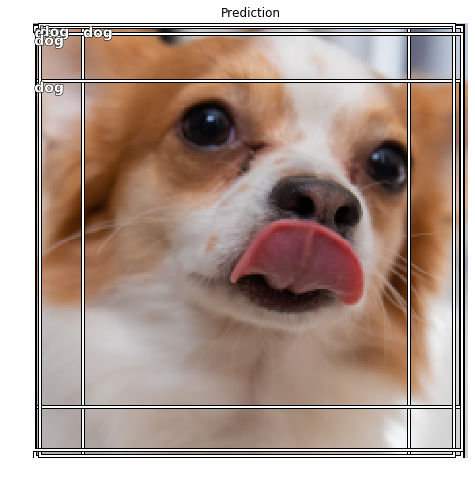

In [0]:
show_img_by_ndx(3)

### Predict Test Images with NMS

In [0]:
# Filter Single Image
def show_filtered_img_by_ndx(idx, d_classes):
      
    # Prepare ground-truth image for display 
    img = vision.Image(denormalize(xb[idx],*tensor(imagenet_stats)))  
        
    # Prrocess NMF 
    tot_bx, tot_cls, scrd_cls_lst = process_nmf(idx, d_classes)  # Filter dupplicate boxes
    if tot_bx is None: return 
    
    # Compose the image, bouding boxes, and classes for display
    p_img_box = ImageBBox.create(224,224,tot_bx.cpu(),tot_cls.cpu(),classes=scrd_cls_lst,scale=False)
  
    # Display resulting image, selected bounding boxes, and class labels
    fig,axes = plt.subplots(1,1,figsize=(15,8))
    img.show(ax=axes,y=p_img_box,title='Prediction', color=colr_list[11])
   

Inferred Class list is empty. Image may be too faint.


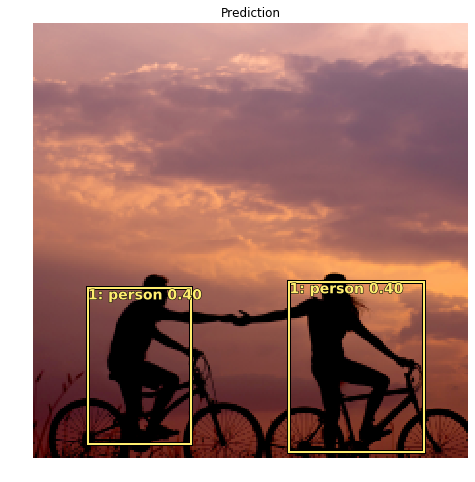

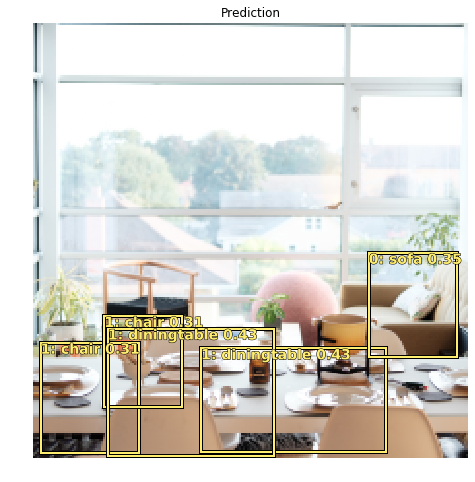

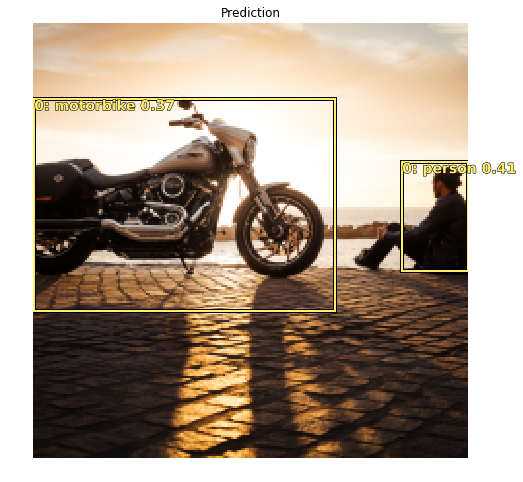

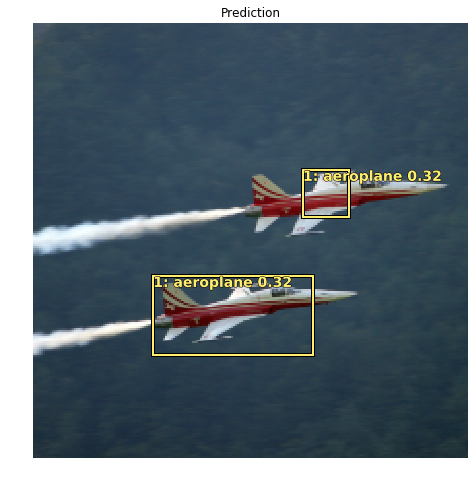

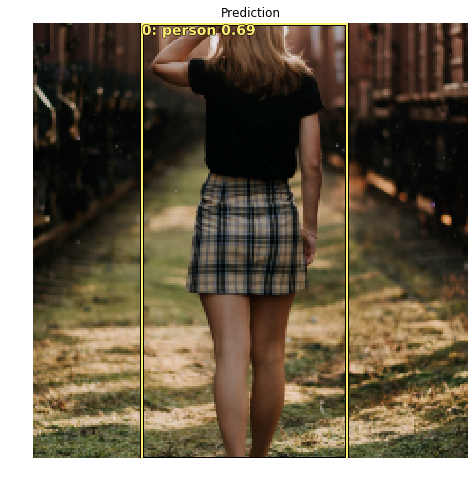

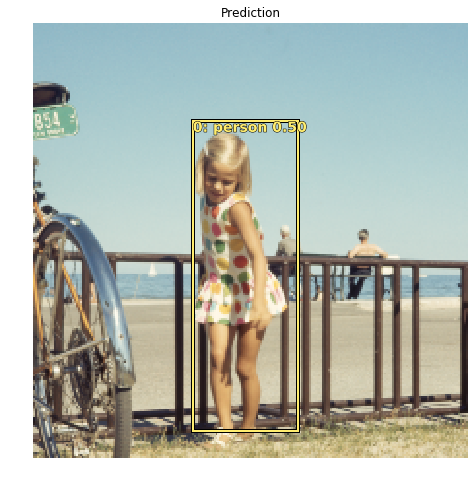

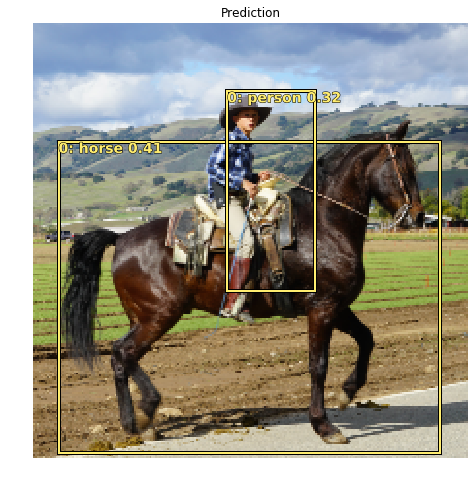

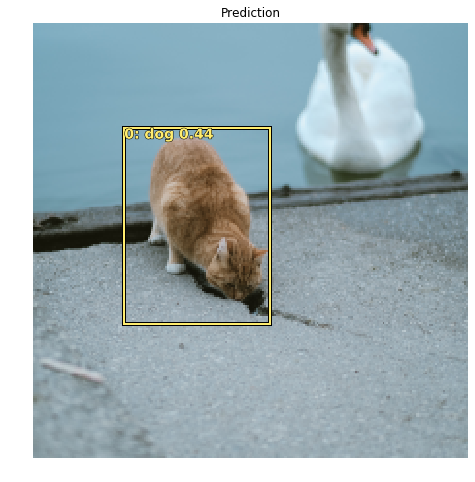

In [0]:
#Filter Image Sets
for i in range(1,10): show_filtered_img_by_ndx(i, data_classes)

# FIN